In [89]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../src/")
sys.path.append("../../src/other")

import os
import pandas as pd
import geopandas as gpd
import numpy as np
import random

import itertools
import folium
from other.utils import display_tile

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
path2split = "../../data/ai4boundaries_ftp_urls_sentinel2_split_stats_v1.csv"
SENTINEL2_DIR = "../../../ai4boundaries_dataset"
path2sub = os.path.join(SENTINEL2_DIR, "representative_images_v1.csv")

path2images, path2masks = os.path.join(SENTINEL2_DIR, "images"), os.path.join(SENTINEL2_DIR, "masks")
path2predicted = os.path.join(SENTINEL2_DIR, "predicted")

# Representatives images

In [85]:
representative_imgs_cat = {
    "small": # small
    ["SI_2366", "SI_2368", "SI_1827", 
"SE_13554", "SE_20088",
"NL_4761", "NL_3590", "NL_2199", "NL_2038",
"LU_217",
"AT_8429", "AT_10183",
"ES_1420"], 
"normal": # normal (average parcel size, shape)
["SI_1965", 
"SE_17336", "SE_16568", "SE_20023", "SE_30539",
"NL_560", "NL_4357", "NL_5150", "NL_1643",
"ES_493", "ES_613"],
"combined": # combined (small + average size parcels in one image)
["SI_2322", 
"NL_1875",
"LU_178",
"FR_63125", "FR_63402",
"AT_9168",
"ES_3756", "ES_888"],
"other": # other problems (mountains, not visible, city, ...)
["SI_1865", # mountains,
"SI_455", # bad gt -> should be nothing in mountains
"SI_289", # no fields
"NL_1894", # town
"NL_5057", # shapes radged
"FR_56385", # mountains, bad gt
"FR_47312", # river + town
"AT_316", # mountains, bad gt
"ES_1620", # very radged edges of parcels
]
}

In [92]:
representative_imgs = list(itertools.chain.from_iterable(list(representative_imgs_cat.values())))

In [93]:
len(representative_imgs)

41

In [4]:
data = pd.read_csv(path2split)

### Distribution of AI4boundaries Luxembourg(Netherlands) image/masks location
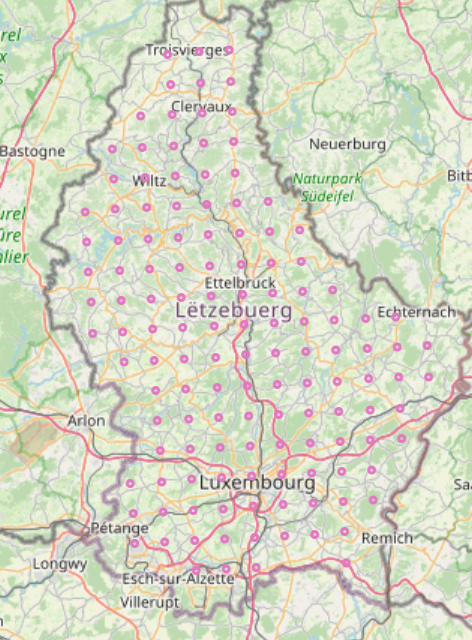
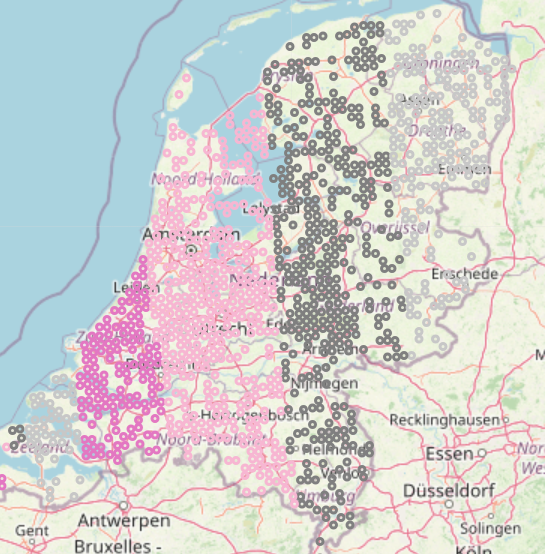

In [ ]:
gdf = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data.lon, data.lat), crs="EPSG:4326"
)
display_tile(gdf, bounds=None, id_name='file_id', tooltip=['file_id', 'n_fields', 'prc_fields',
                                                           'area_min', 'area_max', 'area_mean'],
             name_g="AI4boundaries_representatives", width="100%", height="600px")

In [8]:
data_sub = data[data.file_id.isin(representative_imgs)]

In [39]:
data_sub[['file_id', 'split', 'sentinel2_masks_file_url',
       'sentinel2_images_file_url', 'Country']].head(2)

,file_id,split,sentinel2_masks_file_url,sentinel2_images_file_url,Country
235,ES_613,train,https://jeodpp.jrc.ec.europa.eu/ftp/jrc-openda...,https://jeodpp.jrc.ec.europa.eu/ftp/jrc-openda...,ES
259,FR_56385,train,https://jeodpp.jrc.ec.europa.eu/ftp/jrc-openda...,https://jeodpp.jrc.ec.europa.eu/ftp/jrc-openda...,FR


In [32]:
len(data_sub)

41

In [34]:
data_sub.to_csv(path2sub, index=False)

In [72]:
data_sub.columns

Index(['file_id', 'split', 'sentinel2_masks_file_url',
       'sentinel2_images_file_url', 'Country', 'new_split', 'lat', 'lon',
       'n_fields', 'prc_fields', 'sm_area_cnt', 'bg_area_cnt',
       'sm_solidity_cnt', 'bg_solidity_cnt', 'sm_eccentricity_cnt', 'area_min',
       'perimeter_min', 'solidity_min', 'eccentricity_min', 'extent_min',
       'orientation_min', 'area_mean', 'perimeter_mean', 'solidity_mean',
       'eccentricity_mean', 'extent_mean', 'orientation_mean', 'area_max',
       'perimeter_max', 'solidity_max', 'eccentricity_max', 'extent_max',
       'orientation_max', 'no_field', 'sm_prc_fields', 'sm_num_fields',
       'n_fields_gt', 'n_fields_ls', 'prc_fields_gt', 'prc_fields_ls',
       'sm_area_cnt_gt', 'sm_area_cnt_ls', 'bg_area_cnt_gt', 'bg_area_cnt_ls',
       'sm_solidity_cnt_gt', 'sm_solidity_cnt_ls', 'bg_solidity_cnt_gt',
       'bg_solidity_cnt_ls', 'sm_eccentricity_cnt_gt',
       'sm_eccentricity_cnt_ls'],
      dtype='object')

In [19]:
# location of images visualize
gdf = gpd.GeoDataFrame(
    data_sub, geometry=gpd.points_from_xy(data_sub.lon, data_sub.lat), crs="EPSG:4326"
)
display_tile(gdf, bounds=None, id_name='file_id', tooltip=['file_id', 'n_fields', 'prc_fields',
                                                           'area_min', 'area_max', 'area_mean'],
             name_g="AI4boundaries_representatives", width="100%", height="500px")

In [ ]:
# download images+masks
!python .\download_masks.py -c='' -s=SENTINEL2_DIR -i=path2sub

# Model prediction

In [14]:
from typing import Any, Iterable, Literal, TypeAlias, cast
from numpy.typing import NDArray
import numpy as np
import onnxruntime as ort  # pyright: ignore[reportMissingTypeStubs]
import xarray as xr
from tqdm import tqdm

from other.utils_pred import predict, get_upack_patch

In [63]:
model_path = "..\\..\\model\\model_v1.0.0.onnx" 

os.makedirs(path2predicted, exist_ok=True)

In [64]:
model = ort.InferenceSession(
        model_path,
        providers=["CPUExecutionProvider"],
    )

In [67]:
for file_id in tqdm(representative_imgs):
    images = get_upack_patch(file_id, abs_path=SENTINEL2_DIR) # shape (6, 256, 256, 4)
    predicted = predict(model, images)
    np.save(os.path.join(path2predicted, f'{file_id}.npy'), np.stack(predicted))

# Visualize predictions for the images

## Accuracy computation

In [30]:
from other.accuracy_computation_sim import comp_scores
from matplotlib import pyplot as plt

import rioxarray as rxr
import xarray as xr

from other.utils_pred import get_mask, get_image, get_predicted, get_combined, smooth

In [76]:
_, time_data = get_image(abs_path=SENTINEL2_DIR, file_id=representative_imgs[0])
time_data

array(['2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08'],
      dtype='datetime64[M]')

In [ ]:
# accuracy extent metrics
metrics_all = []
for file_id in tqdm(representative_imgs):
    p_extent, p_boundary, _ = get_predicted(path2predicted, file_id)
    combined, combined_s = get_combined(p_extent, p_boundary, p_limit=0.5)
    extent, boundary, _, _ = get_mask(SENTINEL2_DIR, file_id)
    for idx, p_extent_t in enumerate(p_extent):
        metrics_dict_o = comp_scores(mask_gt=extent.astype(float), mask_pred=np.round(p_extent_t)) # 0, 1 from probability
        metrics_dict_t = comp_scores(mask_gt=extent.astype(float), mask_pred=combined_s[idx])
        metrics_dict_b = comp_scores(mask_gt=boundary.astype(float), mask_pred=np.round(p_boundary[idx]))
        metrics_all.append({
            "file_id": file_id,
            "date": time_data[idx],
            "CADASTRE_fields%": np.round(100 * metrics_dict_o["CADASTRE_fields_prc"], 1),
            "PREDICTED_fields_extent%": np.round(100 * metrics_dict_o["PREDICTED_fields_prc"], 1),
            "PREDICTED_fields_combined%": np.round(100 * metrics_dict_t["PREDICTED_fields_prc"], 1),
            "IoU_pixel_extent": np.round(metrics_dict_o["IoU_pixel"],2),
            "IoU_pixel_combined": np.round(metrics_dict_t["IoU_pixel"],2),
            "IoU_pixel_boundary": np.round(metrics_dict_b["IoU_pixel"],2),
            "Accuracy_pixel_combined": np.round(metrics_dict_t["Accuracy_pixel"],2),
        })

metrics_df = pd.DataFrame(metrics_all)
metrics_df   

In [106]:
# categories of representative images
representative_imgs_cat_ = {item: key for key, item_l in representative_imgs_cat.items() for item in item_l}
metrics_df["category"] = metrics_df.apply(lambda row: representative_imgs_cat_[row["file_id"]], axis=1)
metrics_df["country"] = metrics_df.apply(lambda row: row["file_id"][:2], axis=1)
metrics_df.to_csv(os.path.join(SENTINEL2_DIR, "representative_images_metrics_v1.csv"))

In [107]:
metrics_df.columns

Index(['file_id', 'date', 'CADASTRE_fields%', 'PREDICTED_fields_extent%',
       'PREDICTED_fields_combined%', 'IoU_pixel_extent', 'IoU_pixel_combined',
       'IoU_pixel_boundary', 'Accuracy_pixel_combined', 'category', 'country'],
      dtype='object')

In [109]:
metrics_gr = metrics_df.groupby(by=["category", "country", "date"])[['CADASTRE_fields%', 'PREDICTED_fields_extent%',
       'PREDICTED_fields_combined%', 'IoU_pixel_extent', 'IoU_pixel_combined',
       'IoU_pixel_boundary', 'Accuracy_pixel_combined']].mean()
metrics_gr.to_csv(os.path.join(SENTINEL2_DIR, "representative_images_groupby_metrics_v1.csv"))

In [110]:
# more parcels detected generally in April & July/August (planting/harvesting is happening for summer, winter crops ?)
# predicted IoU is generally higher (July/August - small + average parcels) in April than other months
metrics_gr = metrics_df.groupby(by=["category", "date"])[['CADASTRE_fields%', 'PREDICTED_fields_extent%',
       'PREDICTED_fields_combined%', 'IoU_pixel_extent', 'IoU_pixel_combined',
       'IoU_pixel_boundary', 'Accuracy_pixel_combined']].mean()
metrics_gr

CADASTRE_fields%  PREDICTED_fields_extent%  \
category date                                                     
combined 2019-03-01         76.837500                 73.525000   
         2019-04-01         76.837500                 74.287500   
         2019-05-01         76.837500                 74.750000   
         2019-06-01         76.837500                 75.425000   
         2019-07-01         76.837500                 77.075000   
         2019-08-01         76.837500                 76.225000   
normal   2019-03-01         83.736364                 78.081818   
         2019-04-01         83.736364                 78.727273   
         2019-05-01         83.736364                 80.027273   
         2019-06-01         83.736364                 80.590909   
         2019-07-01         83.736364                 81.000000   
         2019-08-01         83.736364                 79.309091   
other    2019-03-01         17.166667                 15.122222   
         2019-04-01         17.166667                 15.266667   
         2019-05-01         17.166667                 15.611111   
         2019-06-01         17.166667                 17.677778   
         2019-07-01         17.166667                 16.222222   
         2019-08-01         17.166667                 13.722222   
small    2019-03-01         64.007692                 62.992308   
         2019-04-01         64.007692                 64.592308   
         2019-05-01         64.007692                 63.946154   
         2019-06-01         64.007692                 63.953846   
         2019-07-01         64.007692                 63.538462   
         2019-08-01         64.007692                 62.046154   

                     PREDICTED_fields_combined%  IoU_pixel_extent  \
category date                                                       
combined 2019-03-01                   61.462500          0.692500   
         2019-04-01                   61.362500          0.700000   
         2019-05-01                   60.125000          0.668750   
         2019-06-01                   61.162500          0.676250   
         2019-07-01                   63.787500          0.712500   
         2019-08-01                   63.237500          0.713750   
normal   2019-03-01                   69.872727          0.670909   
         2019-04-01                   71.090909          0.684545   
         2019-05-01                   70.027273          0.677273   
         2019-06-01                   69.509091          0.688182   
         2019-07-01                   69.390909          0.697273   
         2019-08-01                   68.336364          0.684545   
other    2019-03-01                   33.266667          0.670000   
         2019-04-01                   32.966667          0.665556   
         2019-05-01                   45.644444          0.642222   
         2019-06-01                   35.133333          0.653333   
         2019-07-01                   33.933333          0.667778   
         2019-08-01                   31.188889          0.682222   
small    2019-03-01                   41.423077          0.706154   
         2019-04-01                   43.561538          0.722308   
         2019-05-01                   43.523077          0.680769   
         2019-06-01                   41.723077          0.677692   
         2019-07-01                   44.992308          0.699231   
         2019-08-01                   43.192308          0.690769   

                     IoU_pixel_combined  IoU_pixel_boundary  \
category date                                                 
combined 2019-03-01            0.602500            0.550000   
         2019-04-01            0.605000            0.566250   
         2019-05-01            0.577500            0.553750   
         2019-06-01            0.580000            0.562500   
         2019-07-01            0.613750            0.573750   
         2019-08-01            0.616250   

In [112]:
# normal and small difference in IoU (IoU_pixel_combined) is ~ 7% (normal is higher / better)
metrics_gr = metrics_df[metrics_df.date == "2019-04-01"].groupby(by=["category"])[['CADASTRE_fields%', 'PREDICTED_fields_extent%',
       'PREDICTED_fields_combined%', 'IoU_pixel_extent', 'IoU_pixel_combined',
       'IoU_pixel_boundary', 'Accuracy_pixel_combined']].mean()
metrics_gr

,CADASTRE_fields%,PREDICTED_fields_extent%,PREDICTED_fields_combined%,IoU_pixel_extent,IoU_pixel_combined,IoU_pixel_boundary,Accuracy_pixel_combined
category,,,,,,,
combined,76.837500,74.287500,61.362500,0.700000,0.605000,0.566250,0.788750
normal,83.736364,78.727273,71.090909,0.684545,0.620000,0.605455,0.834545
other,17.166667,15.266667,32.966667,0.665556,0.405556,0.651111,0.614444
small,64.007692,64.592308,43.561538,0.722308,0.553846,0.574615,0.739231


In [113]:
metrics_gr = metrics_df[metrics_df.country == "ES"].groupby(by=["category", "date"])[['CADASTRE_fields%', 'PREDICTED_fields_extent%',
       'PREDICTED_fields_combined%', 'IoU_pixel_extent', 'IoU_pixel_combined',
       'IoU_pixel_boundary', 'Accuracy_pixel_combined']].mean()
metrics_gr

CADASTRE_fields%  PREDICTED_fields_extent%  \
category date                                                     
combined 2019-03-01             67.95                     69.60   
         2019-04-01             67.95                     68.30   
         2019-05-01             67.95                     64.80   
         2019-06-01             67.95                     66.70   
         2019-07-01             67.95                     68.85   
         2019-08-01             67.95                     67.80   
normal   2019-03-01             88.50                     79.20   
         2019-04-01             88.50                     79.05   
         2019-05-01             88.50                     81.30   
         2019-06-01             88.50                     80.10   
         2019-07-01             88.50                     85.05   
         2019-08-01             88.50                     86.85   
other    2019-03-01             37.00                     29.00   
         2019-04-01             37.00                     30.40   
         2019-05-01             37.00                     30.60   
         2019-06-01             37.00                     33.60   
         2019-07-01             37.00                     34.20   
         2019-08-01             37.00                     33.20   
small    2019-03-01             67.90                     69.80   
         2019-04-01             67.90                     71.90   
         2019-05-01             67.90                     70.00   
         2019-06-01             67.90                     69.60   
         2019-07-01             67.90                     71.30   
         2019-08-01             67.90                     68.60   

                     PREDICTED_fields_combined%  IoU_pixel_extent  \
category date                                                       
combined 2019-03-01                       54.45             0.705   
         2019-04-01                       52.60             0.680   
         2019-05-01                       49.90             0.655   
         2019-06-01                       54.50             0.690   
         2019-07-01                       57.00             0.705   
         2019-08-01                       56.35             0.705   
normal   2019-03-01                       76.70             0.630   
         2019-04-01                       79.35             0.620   
         2019-05-01                       75.05             0.635   
         2019-06-01                       73.85             0.600   
         2019-07-01                       71.25             0.635   
         2019-08-01                       74.05             0.670   
other    2019-03-01                       16.50             0.700   
         2019-04-01                       18.00             0.710   
         2019-05-01                       20.40             0.680   
         2019-06-01                       22.00             0.690   
         2019-07-01                       21.10             0.740   
         2019-08-01                       20.40             0.740   
small    2019-03-01                       56.00             0.610   
         2019-04-01                       59.60             0.610   
         2019-05-01                       59.30             0.620   
         2019-06-01                       58.60             0.610   
         2019-07-01                       60.30             0.620   
         2019-08-01                       56.50             0.610   

                     IoU_pixel_combined  IoU_pixel_boundary  \
category date                                                 
combined 2019-03-01               0.625               0.590   
         2019-04-01               0.590               0.570   
         2019-05-01               0.565               0.555   
         2019-06-01               0.590               0.575   
         2019-07-01               0.615               0.580   
         2019-08-01               0.615   

## Visualizations (rows timestemp).

In [138]:
from other.utils_pred import visualize_predictions

In [114]:
metrics_df["category"].unique()

array(['small', 'normal', 'combined', 'other'], dtype=object)

In [ ]:
category = "normal"
path_to_pdf = os.path.join(SENTINEL2_DIR, f"{category}_representatives_v1.pdf")
date_idx = list(range(0, 6))
viz_factor=3.5
visualize_predictions(metrics_df, path_to_pdf, representative_imgs_cat, SENTINEL2_DIR,
                          path2predicted, category = category,  date_idx =date_idx, viz_factor=viz_factor)

In [ ]:
category = "small"
path_to_pdf = os.path.join(SENTINEL2_DIR, f"{category}_representatives_v1.pdf")
visualize_predictions(metrics_df, path_to_pdf, representative_imgs_cat, SENTINEL2_DIR,
                          path2predicted, category = category,  date_idx =date_idx, viz_factor=viz_factor)

In [ ]:
category = "combined"
path_to_pdf = os.path.join(SENTINEL2_DIR, f"{category}_representatives_v1.pdf")
visualize_predictions(metrics_df, path_to_pdf, representative_imgs_cat, SENTINEL2_DIR,
                          path2predicted, category = category,  date_idx =date_idx, viz_factor=viz_factor)

In [ ]:
category = "other"
path_to_pdf = os.path.join(SENTINEL2_DIR, f"{category}_representatives_v1.pdf")
visualize_predictions(metrics_df, path_to_pdf, representative_imgs_cat, SENTINEL2_DIR,
                          path2predicted, category = category,  date_idx =date_idx, viz_factor=viz_factor)